In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing
from tensorflow.keras import preprocessing , utils
import os

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
spacy.explain("NORP")

In [ ]:
spacy.explain("CARDINAL")

In [ ]:
spacy.explain("GPE")

In [3]:
task1 = open("dataset/dialog-babi-task1-API-calls-trn.txt",'r')
task2 = open("dataset/dialog-babi-task2-API-refine-trn.txt",'r')
files = [task1,task2]

In [4]:
questions = list()
answers = list()

In [5]:
ind = 0
for file in files:
    print("inside file")
    data = file.read()
    lines = data.split("\n")
    for i in lines:
        if len(i)<1:
            continue
        inout=i.split("\t")
        if(len(inout)==1):
            out = inout[0]
            out = out.split(out.split()[0])
            answers[ind-1] = answers[ind-1]+ "\n" +out[1]
        else:
            inp,out = inout[0],inout[1]
            inp=inp.split(inp.split()[0])
            if(inp[1]!=' <SILENCE>'):
                questions.append(inp[1])
                answers.append(out)
                ind+=1
            else:
                answers[ind-1] = answers[ind-1]+', '+out 
    file.close()

inside file
inside file


In [6]:
print(questions[1].strip())
answers[1]

can you book a table


"i'm on it, any preference on a type of cuisine"

In [7]:
answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

In [8]:
answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )
#print(answers)
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 97


In [9]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )

(10522, 19) 19


In [10]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(10522, 20) 20


In [11]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(10522, 20, 97)


In [12]:
encoder_input_data[0]

array([71,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [13]:
decoder_input_data[0]

array([ 1, 23, 32, 20,  8, 33,  3,  7, 34,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [14]:
decoder_output_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# Saving all the arrays to storage
np.save( 'enc_in_data.npy' , encoder_input_data )
np.save( 'dec_in_data.npy' , decoder_input_data )
np.save( 'dec_tar_data.npy' , decoder_output_data )

In [16]:
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    19400       input_1[0][0]                    

In [15]:
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=50, epochs=15 ) 

Train on 10522 samples
Epoch 1/15
10522/10522 [==============================] - 20s 2ms/sample - loss: 0.6131
Epoch 2/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.09750s - loss
Epoch 3/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0906
Epoch 4/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0890
Epoch 5/15
10522/10522 [==============================] - 16s 2ms/sample - loss: 0.0872
Epoch 6/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0831
Epoch 7/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0780
Epoch 8/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0727
Epoch 9/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.0682
Epoch 10/15
10522/10522 [==============================] - 16s 1ms/sample - loss: 0.0651
Epoch 11/15
10522/10522 [==============================] - 15s 1ms/sample - loss: 0.061

In [ ]:
model.save_weights('model_weights.h5')

In [17]:
model.load_weights('model_weights.h5')

In [18]:
import matplotlib.pyplot as plt

In [17]:
print(history.history.keys())

dict_keys(['loss'])


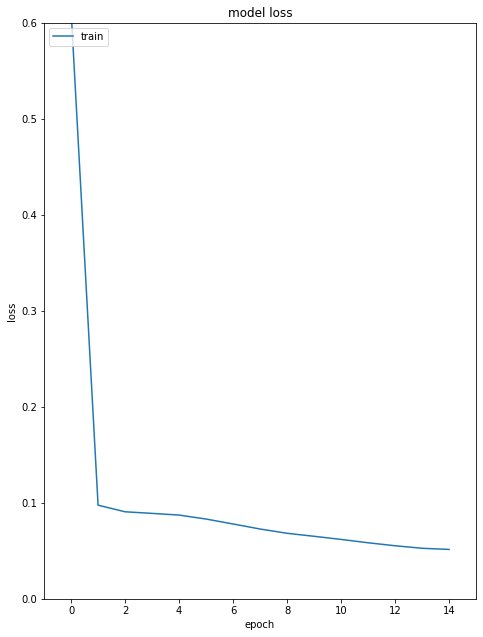

In [32]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,2])
a1.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
a1.set_xlim([-1,15])
a1.set_ylim([0,0.6])
plt.legend(['train'], loc='upper left')
plt.show()

In [19]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [20]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')

In [21]:
enc_model , dec_model = make_inference_models()

In [22]:
print("enter 'close' to close this chat bot\n\n")
res = ""
loc = ""
hmany = ""
price = ""
inp = ""
while(True):
    try:
        inp = input( 'Enter question : ' )
        if(inp=="close"):
            break
        test = nlp(inp)
        for word in test.ents:
            if(word.label_=="NORP"):
                res = word.text
#                 print("food type",word.text)
            if(word.label_=="CARDINAL"):
                hmany = word.text
#                 print("no of people",word.text)
            if(word.label_=="GPE"):
                loc = word.text
#                 print("location",word.text)
        if("moderate" in inp):
            price = "moderate"
        elif("expensive" in inp):
            price = "expensive"
        elif("cheap" in inp):
            price = "cheap"
        states_values = enc_model.predict( str_to_tokens( inp ) )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in tokenizer.word_index.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word

            if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True

            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 
        if(decoded_translation==" you're welcome end" or decoded_translation==" hello what can i help you with today end"):
            res = ""
            loc = ""
            hmany = ""
            price = ""
        if ("api call" in decoded_translation):
            l = list(decoded_translation.rsplit("api call",1)[1].strip().split(" "))
            if(res!=l[0] or hmany!=l[2] or loc!=l[1] or price!=l[3]):
                if(res==""):
                    res = l[0]
                if(hmany==""):
                    hmany = l[2]
                if(loc == ""):
                    loc = l[1]
                if(price == ""):
                    price = l[3]
                temp1,temp2 = decoded_translation.rsplit("api call",1)
                decoded_translation = temp1+"api call "+res+" "+loc+" "+hmany+" "+price+" end"
        print( decoded_translation.replace("  "," "))
        #print(res+loc+hmany+price)
    except KeyError:
        print("sorry i dont know those words!")

enter 'close' to close this chat bot


Enter question : good morning
 hello what can i help you with today end
Enter question : can you book a table in a cheap price range in london
 i'm on it any preference on a type of cuisine end
Enter question : with french food
 where should it be end
Enter question : in london
 how many people would be in your party end
Enter question : for four please
 which price range are looking for end
Enter question : in a cheap price range
 ok let me look into some options for you api call french london four cheap end
Enter question : close


In [22]:
task6 = open("dataset/dialog-babi-task1-API-calls-tst.txt",'r')
task7 = open("dataset/dialog-babi-task2-API-refine-tst.txt",'r')
files = [task6,task7]
questions = list()
answers = list()
ind = 0
for file in files:
    print("inside file")
    data = file.read()
    lines = data.split("\n")
    for i in lines:
        if len(i)<1:
            continue
        i = i.replace("_"," ")
        inout=i.split("\t")
        if(len(inout)==1):
            out = inout[0]
            out = out.split(out.split()[0])
            answers[ind-1] = answers[ind-1]+ "\n" +out[1]
        else:
            inp,out = inout[0],inout[1]
            inp=inp.split(inp.split()[0])
            if(inp[1]!=' <SILENCE>'):
                questions.append(inp[1])
                answers.append(out)
                ind+=1
            else:
                answers[ind-1] = answers[ind-1]+' '+out 
    file.close()

inside file
inside file


In [23]:
answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

In [24]:
len(questions)

10400

In [25]:
len(answers_with_tags)

10400

In [28]:
res = ""
loc = ""
hmany = ""
price = ""
inp = ""
var = 0
count = 0
while(var<len(questions)):
    try:
        inp = questions[var]
        if(inp=="close"):
            break
        test = nlp(inp)
        for word in test.ents:
            if(word.label_=="NORP"):
                res = word.text
#                 print("food type",word.text)
            if(word.label_=="CARDINAL"):
                hmany = word.text
#                 print("no of people",word.text)
            if(word.label_=="GPE"):
                loc = word.text
#                 print("location",word.text)
        if("moderate" in inp):
            price = "moderate"
        elif("expensive" in inp):
            price = "expensive"
        elif("cheap" in inp):
            price = "cheap"
        states_values = enc_model.predict( str_to_tokens( inp ) )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in tokenizer.word_index.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word

            if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True

            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 
        if(decoded_translation==" you're welcome end" or decoded_translation==" hello what can i help you with today end"):
            res = ""
            loc = ""
            hmany = ""
            price = ""
        if ("api call" in decoded_translation):
            l = list(decoded_translation.rsplit("api call",1)[1].strip().split(" "))
            if(res!=l[0] or hmany!=l[2] or loc!=l[1] or price!=l[3]):
                if(res==""):
                    res = l[0]
                if(hmany==""):
                    hmany = l[2]
                if(loc == ""):
                    loc = l[1]
                if(price == ""):
                    price = l[3]
                temp1,temp2 = decoded_translation.rsplit("api call",1)
                decoded_translation = temp1+"api call "+res+" "+loc+" "+hmany+" "+price+" end"
        decoded_translation = decoded_translation.replace("  "," ")
        decoded_translation = decoded_translation.replace("end","")
        decoded_translation = decoded_translation.strip()
        if(answers_with_tags[var] == decoded_translation):
            count+=1
        else:
            print(decoded_translation,var)
            print(answers_with_tags[var],var)
#             break
        #print(res+loc+hmany+price)
    except KeyError:
        print("sorry i dont know those words!")
    var+=1

where should it be 2
how many people would be in your party 2
which price range are looking for 3
ok let me look into some options for you api call french london four cheap 3
how many people would be in your party 12
ok let me look into some options for you api call british madrid eight cheap 12
which price range are looking for 17
ok let me look into some options for you api call indian bombay four moderate 17
which price range are looking for 20
ok let me look into some options for you api call indian london four moderate 20
which price range are looking for 28
ok let me look into some options for you api call spanish london two moderate 28
which price range are looking for 31
ok let me look into some options for you api call british london two expensive 31
how many people would be in your party 34
which price range are looking for 34
where should it be 54
how many people would be in your party 54
how many people would be in your party 59
ok let me look into some options for you api 

which price range are looking for 642
ok let me look into some options for you api call spanish paris two moderate 642
where should it be 647
how many people would be in your party 647
which price range are looking for 648
ok let me look into some options for you api call italian bombay eight cheap 648
how many people would be in your party 652
ok let me look into some options for you api call french rome four expensive 652
which price range are looking for 657
ok let me look into some options for you api call spanish paris six cheap 657
where should it be 660
ok let me look into some options for you api call british madrid four moderate 660
where should it be 667
how many people would be in your party 667
which price range are looking for 668
ok let me look into some options for you api call british paris eight expensive 668
which price range are looking for 673
ok let me look into some options for you api call italian bombay four expensive 673
where should it be 678
ok let me look in

how many people would be in your party 1280
ok let me look into some options for you api call italian london six moderate 1280
how many people would be in your party 1283
which price range are looking for 1283
where should it be 1287
which price range are looking for 1287
which price range are looking for 1291
ok let me look into some options for you api call spanish london six moderate 1291
how many people would be in your party 1295
which price range are looking for 1295
where should it be 1315
ok let me look into some options for you api call french london six cheap 1315
how many people would be in your party 1324
which price range are looking for 1324
where should it be 1328
how many people would be in your party 1328
which price range are looking for 1333
ok let me look into some options for you api call french london six cheap 1333
which price range are looking for 1337
ok let me look into some options for you api call italian paris two moderate 1337
how many people would be in y

how many people would be in your party 2000
which price range are looking for 2000
where should it be 2009
which price range are looking for 2009
where should it be 2013
which price range are looking for 2013
where should it be 2023
how many people would be in your party 2023
where should it be 2030
which price range are looking for 2030
how many people would be in your party 2035
ok let me look into some options for you api call indian paris four cheap 2035
how many people would be in your party 2045
ok let me look into some options for you api call british london two expensive 2045
where should it be 2058
ok let me look into some options for you api call indian rome six expensive 2058
which price range are looking for 2075
ok let me look into some options for you api call british rome eight expensive 2075
which price range are looking for 2084
ok let me look into some options for you api call french madrid eight moderate 2084
how many people would be in your party 2087
which price ra

where should it be 2530
ok let me look into some options for you api call italian london four moderate 2530
how many people would be in your party 2539
which price range are looking for 2539
how many people would be in your party 2544
ok let me look into some options for you api call spanish london eight moderate 2544
how many people would be in your party 2547
which price range are looking for 2547
where should it be 2551
ok let me look into some options for you api call indian london two cheap 2551
how many people would be in your party 2560
which price range are looking for 2560
where should it be 2569
how many people would be in your party 2569
which price range are looking for 2570
ok let me look into some options for you api call italian bombay six cheap 2570
where should it be 2573
which price range are looking for 2573
where should it be 2584
ok let me look into some options for you api call french london two cheap 2584
how many people would be in your party 2608
ok let me look

which price range are looking for 3175
ok let me look into some options for you api call british bombay four expensive 3175
which price range are looking for 3178
ok let me look into some options for you api call italian bombay four expensive 3178
how many people would be in your party 3188
which price range are looking for 3188
where should it be 3215
how many people would be in your party 3215
how many people would be in your party 3221
which price range are looking for 3221
how many people would be in your party 3241
which price range are looking for 3241
where should it be 3271
ok let me look into some options for you api call italian rome eight expensive 3271
which price range are looking for 3275
ok let me look into some options for you api call british london eight moderate 3275
which price range are looking for 3280
ok let me look into some options for you api call french madrid four cheap 3280
which price range are looking for 3283
ok let me look into some options for you api 

how many people would be in your party 3763
which price range are looking for 3763
how many people would be in your party 3767
ok let me look into some options for you api call spanish london four moderate 3767
how many people would be in your party 3778
ok let me look into some options for you api call spanish paris six expensive 3778
where should it be 3784
ok let me look into some options for you api call spanish london two moderate 3784
where should it be 3789
ok let me look into some options for you api call indian london six expensive 3789
how many people would be in your party 3792
which price range are looking for 3792
how many people would be in your party 3812
which price range are looking for 3812
how many people would be in your party 3818
ok let me look into some options for you api call british rome four expensive 3818
where should it be 3823
how many people would be in your party 3823
how many people would be in your party 3828
which price range are looking for 3828
how 

In [29]:
print("total = ",len(questions),"\ncorrect = ",count)

total =  10400 
correct =  9892


In [30]:
print((count*100)/len(questions),"%")

95.11538461538461 %
